# Read input data

In [2]:
import re
import pprint
import os
# import numpy as np
# from scipy.stats import chi2

# Define a pattern to match the relevant data
RE_IGNORE_OPTIONAL_LINE = r'(?:[^\n]*)?'
pattern = [
    r'Running ([\./\w]+) on (\w+)[^\n]*',
    RE_IGNORE_OPTIONAL_LINE,
    RE_IGNORE_OPTIONAL_LINE,
    r'Number of threads: (\d+)',
    r'Runtime: (\d+\.[\d]+)'
]
pattern = r'\n?'.join(pattern) # This ? may cause unexpected behavior
print(f'Pattern: {pattern}')

pattern_beamer = [
    r'Running ([\./\w]+) on (\w+)[^\n]*',
    RE_IGNORE_OPTIONAL_LINE,
    RE_IGNORE_OPTIONAL_LINE,
    RE_IGNORE_OPTIONAL_LINE,
    RE_IGNORE_OPTIONAL_LINE,
    r'Average Time: +(\d+\.[\d]+)'
]
pattern_beamer = r'\n?'.join(pattern_beamer) # This ? may cause unexpected behavior
print(f'Pattern reference: {pattern_beamer}')

# List all files in the 'data_runtime' directory
all_files = os.listdir('data_runtime')

# Filter files that start with 'runtime_'
runtime_files = [f for f in all_files if f.startswith('runtime_')]

runtimes = {}

dataset_category = {
    'Social_Network_1':         'small',
    'Web_Graph_1':              'small',
    'Collaboration_Network_1':  'small',
    'Synthetic_Dense_1':        'small',
    'Road_Network_1':           'large',
    'kNN_Graph_1':              'large',
    'Synthetic_Sparse_1':       'large',
    'Road_Network_2':           'large',
}

for runtime_file in runtime_files:
    print(f'Parsing {runtime_file}...')
    with open(f'data_runtime/{runtime_file}', 'r') as file:
        file_format = file.read()

    # Find all matches in the string
    matches = re.findall(pattern if 'beamer' not in runtime_file else pattern_beamer, file_format)
    print(f'Found {len(matches)} matches')
    program = runtime_file[len('runtime_'):-4]
    # program = ''.join([i for i in program if not i.isdigit()])
    program = program.split('_')
    output = program[0]
    threads = int(program[-1])
    program = None if len(program) <= 2 else program[1]
    
    # Convert matches to a list of dictionaries
    for match in matches:
        if 'beamer' in runtime_file:
            binary = match[0]
            dataset = match[1]
            runtime = float(match[2])
        else:
            binary = match[0]
            dataset = match[1]
            runtime = float(match[3])
        if program is None:
            program_local = dataset_category[dataset]
        else:
            program_local = program
        # Init dictionary
        if runtimes.get(output) == None:
            runtimes[output] = {}
        if runtimes[output].get(program_local) == None:
            runtimes[output][program_local] = {}
        if runtimes[output][program_local].get(threads) == None:
            runtimes[output][program_local][threads] = {}
        if runtimes[output][program_local][threads].get(dataset) == None:
            runtimes[output][program_local][threads][dataset] = []

        runtimes[output][program_local][threads][dataset].append({'binary': binary, 'threads': threads, 'runtime': runtime})

# pprint.pprint(runtimes)

average_runtimes = {}
for output in runtimes.keys():
    if average_runtimes.get(output) is None:
        average_runtimes[output] = {}
    for program, threads_l in runtimes[output].items():
        if average_runtimes[output].get(program) is None:
            average_runtimes[output][program] = {}
        for threads, datasets in threads_l.items():
            if average_runtimes[output][program].get(threads) is None:
                average_runtimes[output][program][threads] = {}
            for dataset, entries in datasets.items():
                total_runtime = sum(float(entry['runtime']) for entry in entries)
                average_runtime = total_runtime / len(entries)
                average_runtimes[output][program][threads][dataset] = average_runtime

sequential_naive = None
if 'sequential_naive' in average_runtimes:
    sequential_naive = average_runtimes['sequential_naive'][list(average_runtimes['sequential_naive'].keys())[0]]
    del average_runtimes['sequential_naive']

pprint.pprint(average_runtimes)

Pattern: Running ([\./\w]+) on (\w+)[^\n]*\n?(?:[^\n]*)?\n?(?:[^\n]*)?\n?Number of threads: (\d+)\n?Runtime: (\d+\.[\d]+)
Pattern reference: Running ([\./\w]+) on (\w+)[^\n]*\n?(?:[^\n]*)?\n?(?:[^\n]*)?\n?(?:[^\n]*)?\n?(?:[^\n]*)?\n?Average Time: +(\d+\.[\d]+)
Parsing runtime_distances_8.log...
Found 80 matches
Parsing runtime_distances_12.log...
Found 80 matches
Parsing runtime_distances_16.log...
Found 80 matches
Parsing runtime_beamer_32.log...
Found 80 matches
Parsing runtime_beamer_24.log...
Found 80 matches
Parsing runtime_distances_small_32.log...
Found 80 matches
Parsing runtime_distances_24.log...
Found 80 matches
Parsing runtime_distances_large_32.log...
Found 80 matches
Parsing runtime_distances_classic_32.log...
Found 80 matches
Parsing runtime_parents_24.log...
Found 80 matches
Parsing runtime_distances_4.log...
Found 80 matches
Parsing runtime_parents_small_32.log...
Found 80 matches
Parsing runtime_distances_classic_24.log...
Found 80 matches
Parsing runtime_distances_1.

# Generate plots on runtime and speedups

In [3]:
import numpy as np
import matplotlib.pyplot as plt

FONT_TITLE = 18
FONT_AXES = 18
FONT_TICKS = 14
FONT_LEGEND = 14
dataset_sizes = {
    'Web_Graph_1':              (6558851,294259270),
    'Social_Network_1':         (4799030,83971060),
    'Collaboration_Network_1':  (1058365,110391514),
    'Synthetic_Dense_1':        (9899865,980075384),
    'kNN_Graph_1':              (24627858,154302284),
    'Synthetic_Sparse_1':       (9899865,39202750),
    'Road_Network_1':           (21872120,58216498),
    'Road_Network_2':           (86081964,215900378),
}

def human_readable_size(size):
    if size >= 1e9:
        return f'{size / 1e9:.1f} B'
    else:
        return f'{size / 1e6:.1f} M'
for dataset, (nodes, edges) in dataset_sizes.items():
    print(f'{dataset:<30}: {human_readable_size(nodes):<5} nodes, {human_readable_size(edges)} edges')

category_colors = {
    'small': 'blue',
    'large': 'green',
    'verylarge': 'green',
}
datasets = list(dataset_category.keys())
BASELINE_PROGRAM = 'beamer' # sbeamer_four_twfour sbeamer_fiftn_eigtn
programs = [
    # 'small96',
    # 'large96',
    # 'verylarge96',
    # 'auto96',

    # 'small24',
    # 'large24',
    # 'verylarge24',
    # 'auto24',

    # BASELINE_PROGRAM,
    'small',
    'large',
    'classic'
]

# Calculate speedups
speedups = {}
for output in average_runtimes.keys():
    speedups[output] = {}
    for program in programs:
        program_threads = average_runtimes[output].get(program, {})
        speedups[output][program] = {}
        for threads, program_datasets in program_threads.items():
            speedups[output][program][threads] = {}
            for dataset, runtime in program_datasets.items():
                if threads in average_runtimes[BASELINE_PROGRAM][dataset_category[dataset]]:
                    if dataset in average_runtimes[BASELINE_PROGRAM][dataset_category[dataset]][threads]:
                        speedups[output][program][threads][dataset] = average_runtimes[BASELINE_PROGRAM][dataset_category[dataset]][threads][dataset] / runtime
                else:
                    speedups[output][program][threads][dataset] = 0



eps = {}
for program in programs:
    program_threads = average_runtimes['distances'].get(program, {})
    eps[program] = {}
    for threads, program_datasets in program_threads.items():
        eps[program][threads] = {}
        for dataset, runtime in program_datasets.items():
            if threads in average_runtimes['distances'][program]:
                if dataset in average_runtimes['distances'][program][threads]:
                    eps[program][threads][dataset] = dataset_sizes[dataset][1] / runtime
            else:
                eps[program][threads][dataset] = 0

# if sequential_naive is not None:
#     speedups_naive = {}
#     for program in programs:
#         program_threads = average_runtimes['distances'].get(program, {})
#         speedups_naive[program] = {}
#         for threads, program_datasets in program_threads.items():
#             speedups_naive[program][threads] = {}
#             for dataset, runtime in program_datasets.items():
#                 if dataset in average_runtimes[program][threads]:
#                     speedups_naive[program][threads][dataset] = sequential_naive[dataset] / runtime

speedups_scalability = {}
for program in programs:
    if program == 'classic':
        continue
    program_threads = average_runtimes['distances'].get(program, {})
    speedups_scalability[program] = {}
    for threads, program_datasets in program_threads.items():
        speedups_scalability[program][threads] = {}
        for dataset, runtime in program_datasets.items():
            if program == dataset_category[dataset]:
                print(f'{program} on {dataset} with {threads} threads')
                ref_runtime = average_runtimes['distances'][program][1].get(dataset)
                # if ref_runtime is None:
                #     print(f'WARNING: Reference runtime for {program} on {dataset} with 1 thread is None and has been set to 60s')
                speedups_scalability[program][threads][dataset] = (60 if ref_runtime is None else ref_runtime) / runtime

print("===== SPEEDUPS =====")
pprint.pprint(speedups)
print("\n===== SPEEDUPS SCALABILITY =====")
pprint.pprint(speedups_scalability)
print("\n===== Edges/s =====")
pprint.pprint(eps)

Web_Graph_1                   : 6.6 M nodes, 294.3 M edges
Social_Network_1              : 4.8 M nodes, 84.0 M edges
Collaboration_Network_1       : 1.1 M nodes, 110.4 M edges
Synthetic_Dense_1             : 9.9 M nodes, 980.1 M edges
kNN_Graph_1                   : 24.6 M nodes, 154.3 M edges
Synthetic_Sparse_1            : 9.9 M nodes, 39.2 M edges
Road_Network_1                : 21.9 M nodes, 58.2 M edges
Road_Network_2                : 86.1 M nodes, 215.9 M edges
small on Web_Graph_1 with 8 threads
small on Collaboration_Network_1 with 8 threads
small on Synthetic_Dense_1 with 8 threads
small on Social_Network_1 with 8 threads
small on Web_Graph_1 with 12 threads
small on Collaboration_Network_1 with 12 threads
small on Synthetic_Dense_1 with 12 threads
small on Social_Network_1 with 12 threads
small on Web_Graph_1 with 16 threads
small on Collaboration_Network_1 with 16 threads
small on Synthetic_Dense_1 with 16 threads
small on Social_Network_1 with 16 threads
small on Web_Graph_

## Plot speedups

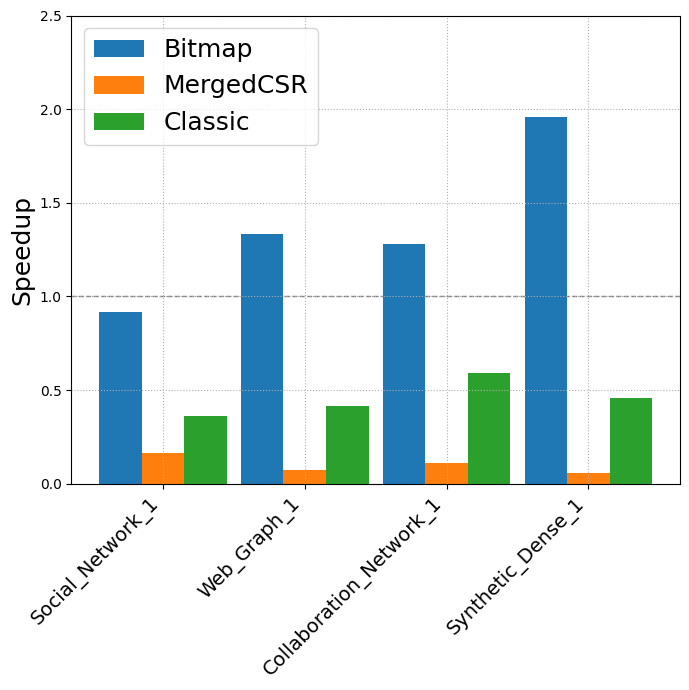

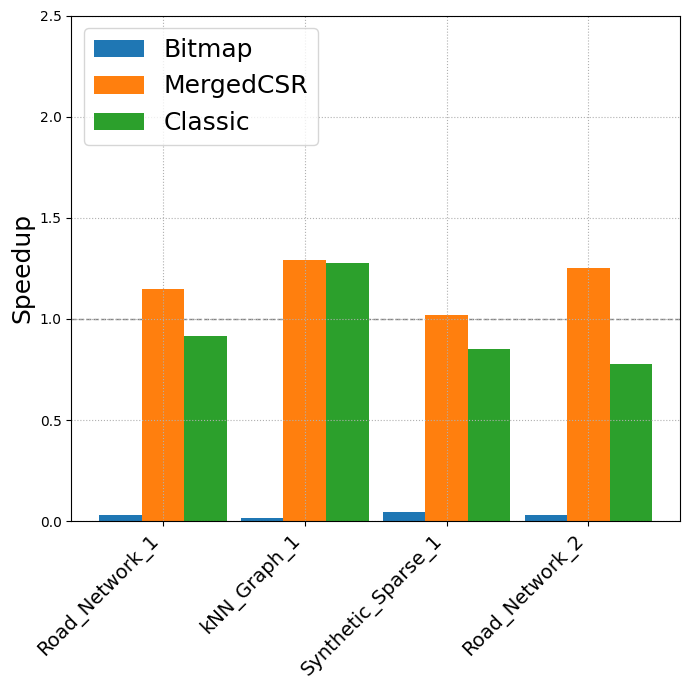

In [4]:
small_datasets = [d for d in datasets if dataset_category[d] == 'small']
large_datasets = [d for d in datasets if dataset_category[d] == 'large']

FONT_TITLE = 18
FONT_AXES = 18
FONT_LEGEND = 18
BAR_WIDTH = 0.3

PROGRAM_LABELS = {
    'small': 'Bitmap',
    'large': 'MergedCSR',
    'classic': 'Classic',
}

# Remap names of datasets
dataset_labels = {
    'Web_Graph_1': 'Web\nGraph',
    'Social_Network_1': 'Social\nNetwork',
    'Collaboration_Network_1': 'Collab.\nNetwork',
    'Synthetic_Dense_1': 'Synthetic\nDense',
    'kNN_Graph_1': 'kNN\nGraph',
    'Synthetic_Sparse_1': 'Synthetic\nSparse',
    'Road_Network_1': 'Road\nNetwork 1',
    'Road_Network_2': 'Road\nNetwork 2',
}

_threads = [32]

import os

# Create the plots directory if it does not exist
os.makedirs('plots', exist_ok=True)

for threads in _threads:
    for dataset_group in (small_datasets, large_datasets):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, zorder=0)
        for i, program in enumerate(programs):
            program_speedups = speedups['distances'][program][threads]
            speedup_values = [program_speedups.get(dataset, np.nan) for dataset in dataset_group]
            bars = ax.bar(np.arange(len(dataset_group)) + i * BAR_WIDTH, speedup_values, BAR_WIDTH, label=PROGRAM_LABELS[program])
            for bar, dataset in zip(bars, dataset_group):
                eps_value = eps[program][threads].get(dataset, np.nan)
                # if np.isnan(eps_value):
                #     ax.text(bar.get_x() + bar.get_width() / 4, 0, 'x')
                # else:
                #     if eps_value >= 1e9:
                #         formatted_eps_value = f'{eps_value / 1e9:.1f}B'
                #     else:
                #         formatted_eps_value = f'{eps_value / 1e6:.1f}M'
                #     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), formatted_eps_value, ha='center', va='bottom', fontsize=FONT_TICKS-2)

        ax.set_ylabel('Speedup', fontsize=FONT_AXES)
        ax.set_xticks(np.arange(len(dataset_group)) + BAR_WIDTH)
        ax.set_xticklabels(dataset_group, rotation=45, ha='right', fontsize=FONT_TICKS)
        ax.set_ylim(0, 2.5)
        ax.legend(loc='upper left', fontsize=FONT_LEGEND)
        ax.grid(True, linestyle=':')
        fig.tight_layout()
        plt.show()
        fig.savefig(f'plots/speedup_{threads}_distances_{"small" if dataset_group == small_datasets else "large"}.pdf')

## Plot Edges/s

In [5]:
import pandas as pd
_threads = [32]

for threads in _threads:
    # Create a DataFrame for eps
    eps_data = []
    for program, threads_data in eps.items():
        threads_data = threads_data[threads]
        for dataset, value in threads_data.items():
            eps_data.append([program, threads, dataset, value])

    eps_df = pd.DataFrame(eps_data, columns=['Program', 'Threads', 'Dataset', 'Edges/s'])
    eps_df_pivot = eps_df.pivot_table(index=['Dataset', 'Threads'], columns='Program', values='Edges/s')
    # print(eps_df_pivot)

    def format_number(x):
        if x >= 1e9:
            return f'{x / 1e9:.1f}B'
        elif x >= 1e6:
            return f'{x / 1e6:.1f}M'
        else:
            return f'{x:.1f}'
    formatted_eps_df_pivot = eps_df_pivot.map(format_number)
    print(formatted_eps_df_pivot)
    print(formatted_eps_df_pivot.to_latex())

Program                         classic   large  small
Dataset                 Threads                       
Collaboration_Network_1 32        11.6B    2.1B  25.2B
Road_Network_1          32       280.2M  350.5M   9.3M
Road_Network_2          32       320.3M  516.0M  11.8M
Social_Network_1        32         2.2B    1.0B   5.6B
Synthetic_Dense_1       32         8.7B    1.0B  37.0B
Synthetic_Sparse_1      32       259.9M  311.8M  14.4M
Web_Graph_1             32         5.5B  998.7M  17.8B
kNN_Graph_1             32         3.1B    3.1B  39.2M
\begin{tabular}{lllll}
\toprule
 & Program & classic & large & small \\
Dataset & Threads &  &  &  \\
\midrule
Collaboration_Network_1 & 32 & 11.6B & 2.1B & 25.2B \\
\cline{1-5}
Road_Network_1 & 32 & 280.2M & 350.5M & 9.3M \\
\cline{1-5}
Road_Network_2 & 32 & 320.3M & 516.0M & 11.8M \\
\cline{1-5}
Social_Network_1 & 32 & 2.2B & 1.0B & 5.6B \\
\cline{1-5}
Synthetic_Dense_1 & 32 & 8.7B & 1.0B & 37.0B \\
\cline{1-5}
Synthetic_Sparse_1 & 32 & 259.9M 

# Generate scalability plots

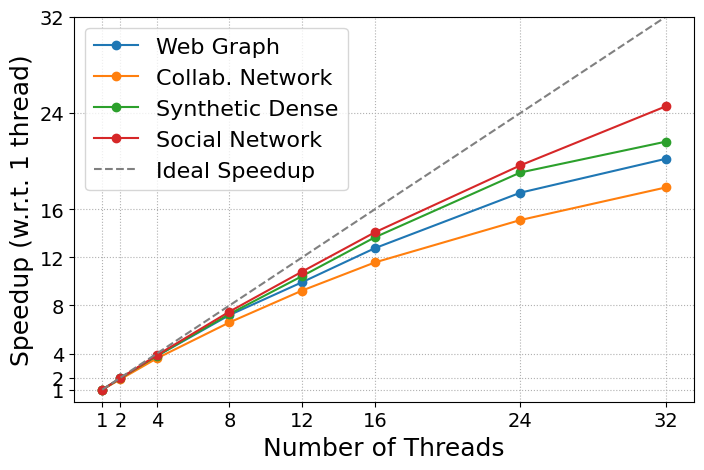

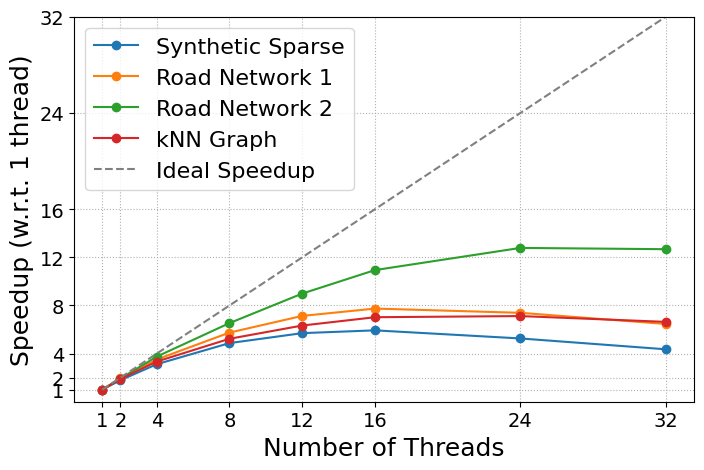

In [6]:
FONT_TITLE = 18
FONT_AXES = 18
FONT_TICKS = 14
FONT_LEGEND = 16

for program in programs:
    if program == 'classic':
        continue
    fig, ax = plt.subplots(figsize=(8, 5))
    thread_counts = sorted(speedups_scalability[program].keys())
    for dataset in speedups_scalability[program][1].keys():
        speedup_values = [speedups_scalability[program][threads].get(dataset, np.nan) for threads in thread_counts]
        ax.plot(thread_counts, speedup_values, marker='o', label=dataset_labels[dataset].replace('\n', ' '))
    
    # Ideal speedup
    ax.plot(thread_counts, thread_counts, '--', color='gray', label='Ideal Speedup')

    ax.set_xlabel('Number of Threads', fontsize=FONT_AXES)
    ax.set_ylabel('Speedup (w.r.t. 1 thread)', fontsize=FONT_AXES)
    # ax.set_title(f'Scaling on graphs with {"large" if program=="small" else "small"} frontiers', fontsize=FONT_TITLE)
    ax.set_xticks(thread_counts)
    ax.set_xticklabels(thread_counts, fontsize=FONT_TICKS)
    ax.set_yticks(thread_counts)
    ax.set_yticklabels(thread_counts, fontsize=FONT_TICKS)
    # ax.set_xlim((0,8))
    ax.set_ylim((0,32))
    ax.legend(loc='best', fontsize=FONT_LEGEND)
    ax.grid(True, linestyle=':')
    plt.show()
    fig.savefig(f'plots/scalability_{program}.pdf')

# Comparison with Beamer

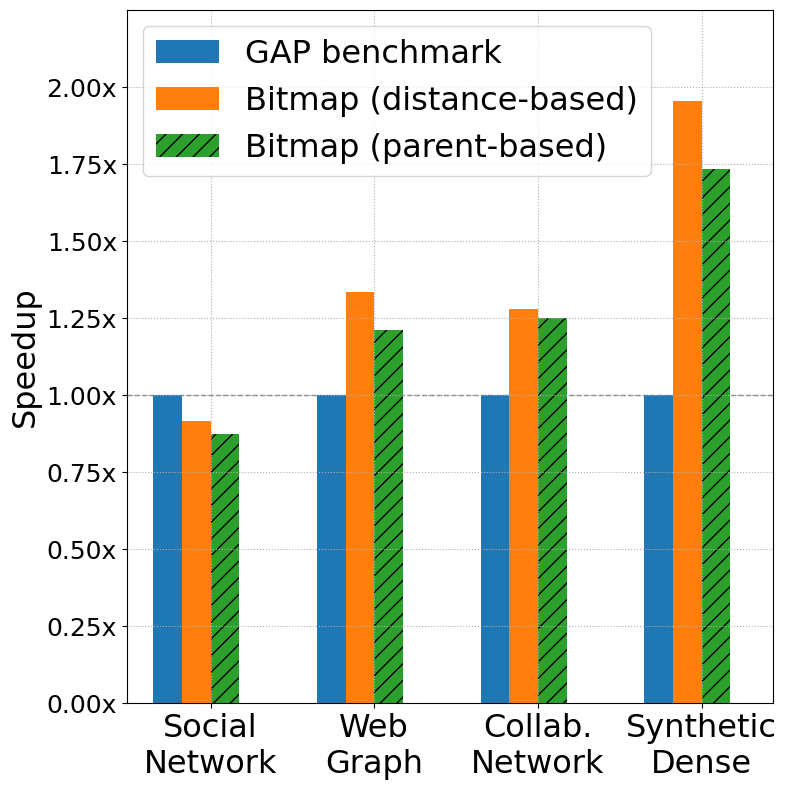

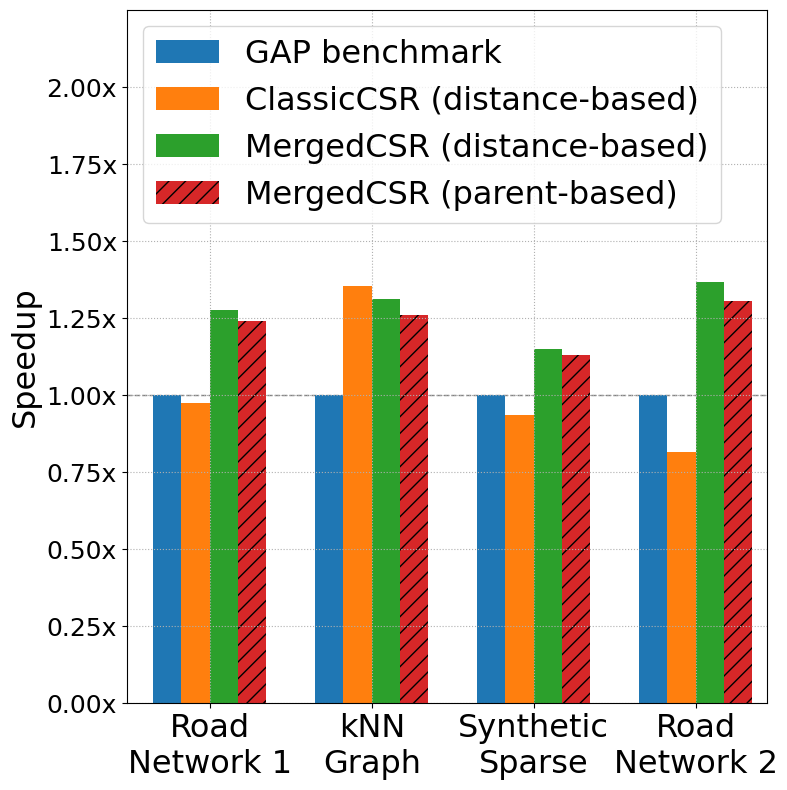

In [ ]:
BAR_WIDTH = 0.35
FONT_XTICKS = 23
FONT_YTICKS = 18
FONT_AXES = 23
FONT_LEGEND = 23

# Define the datasets and programs
small_datasets = [d for d in datasets if dataset_category[d] == 'small']
large_datasets = [d for d in datasets if dataset_category[d] == 'large']

# Create the plots directory if it does not exist
os.makedirs('plots', exist_ok=True)
# Plot the speedup for each dataset
for dataset_group, program_key, threads in zip([small_datasets, large_datasets], ['small', 'large'], [32, 24]):
  fig, ax = plt.subplots(figsize=(8, 8))
  
  ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, zorder=0)
  program_speedups_distances = speedups['distances'][program_key][threads]
  program_speedups_parents = speedups['parents'][program_key][threads]
  program_speedups_classic = speedups['distances']['classic'][threads]
  
  speedup_values_distances = [program_speedups_distances.get(dataset, np.nan) for dataset in dataset_group]
  speedup_values_parents = [program_speedups_parents.get(dataset, np.nan) for dataset in dataset_group]
  speedup_values_classic = [program_speedups_classic.get(dataset, np.nan) for dataset in dataset_group]
  
  bar_positions = np.arange(len(dataset_group)) * 2  # Increase the distance between the bars
  # Add Beamer bars
  beamer_values = [1] * len(dataset_group)
  beamer_bars = ax.bar(bar_positions, beamer_values, BAR_WIDTH, label='GAP benchmark')
  bars_distances = ax.bar(bar_positions + BAR_WIDTH, speedup_values_distances, BAR_WIDTH, label=f'{PROGRAM_LABELS[program_key]} (distance-based)')
  bars_parents = ax.bar(bar_positions + 2 * BAR_WIDTH, speedup_values_parents, BAR_WIDTH, label=f'{PROGRAM_LABELS[program_key]} (parent-based)', hatch='//')
  if program_key == 'large':
    bars_classic = ax.bar(bar_positions + 3 * BAR_WIDTH, speedup_values_classic, BAR_WIDTH, label=f'{PROGRAM_LABELS["classic"]}CSR (distance-based)')
  
  ax.tick_params(axis='y', labelsize=FONT_YTICKS)
  ax.set_ylabel('Speedup', fontsize=FONT_AXES)
  ax.set_xticks(bar_positions + 1.5 * BAR_WIDTH)
  ax.set_xticklabels([dataset_labels[dataset] for dataset in dataset_group], ha='center', fontsize=FONT_XTICKS)
  
  
  ax.set_ylim(0, 2.25)
  ax.set_yticks(np.arange(0, 2.25, 0.25))
  ax.set_yticklabels([f'{tick:.2f}x' for tick in np.arange(0, 2.25, 0.25)])
  #set vertical align of y ticks to top

  ax.set_xlim(-0.5, bar_positions[-1] + 4 * BAR_WIDTH)
  ax.legend(loc='upper left', fontsize=FONT_LEGEND)
  ax.grid(True, linestyle=':')

  fig.tight_layout()
  plt.show()
  fig.savefig(f'plots/speedup_beamer_{threads}_{"small" if dataset_group == small_datasets else "large"}.pdf')


# Geomeans

In [368]:
from scipy.stats import gmean

# Extract speedup values for distances analysis
distances_speedup_values = {}
for program, threads in (['small', 32], ['large', 24]):
  if program == 'classic':
    continue
  distances_speedup_values[program] = []
  for dataset in speedups['distances'][program][threads].keys():
    if dataset_category[dataset] == program:
      distances_speedup_values[program].append(speedups['distances'][program][threads][dataset])

# Calculate the geometric mean of the speedup values
distances_gmean_values = {program: gmean(values) for program, values in distances_speedup_values.items()}
print(f"--- DISTANCES ANALYSIS ---")
print(f"Geomean of small diameter speedups (large frontiers): {distances_gmean_values['small']:.2f}x")
print(f"Geomean of large diameter speedups (small frontiers): {distances_gmean_values['large']:.2f}x")
geomean_all = gmean([
    value 
    for program in distances_speedup_values.values()
    for value in program
])
print(f"Geomean of all speedups: {geomean_all:.2f}x")


distances_speedup_values = {}
for program, threads in (['small', 32], ['large', 24]):
  if program == 'classic':
    continue
  distances_speedup_values[program] = []
  for dataset in speedups['parents'][program][threads].keys():
    if dataset_category[dataset] == program:
      distances_speedup_values[program].append(speedups['parents'][program][threads][dataset])

# Calculate the geometric mean of the speedup values
distances_gmean_values = {program: gmean(values) for program, values in distances_speedup_values.items()}
print(f"\n--- PARENTS ANALYSIS ---")
print(f"Geomean of small diameter speedups (large frontiers): {distances_gmean_values['small']:.2f}x")
print(f"Geomean of large diameter speedups (small frontiers): {distances_gmean_values['large']:.2f}x")
geomean_all = gmean([
    value 
    for program in distances_speedup_values.values()
    for value in program
])
print(f"Geomean of all speedups: {geomean_all:.2f}x")

--- DISTANCES ANALYSIS ---
Geomean of small diameter speedups (large frontiers): 1.32x
Geomean of large diameter speedups (small frontiers): 1.27x
Geomean of all speedups: 1.30x

--- PARENTS ANALYSIS ---
Geomean of small diameter speedups (large frontiers): 1.23x
Geomean of large diameter speedups (small frontiers): 1.23x
Geomean of all speedups: 1.23x
